In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def create_folder(path):
    try:
        os.mkdir(path)
    except:
        pass

In [3]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}

facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'

def plot_graphs(df,country,save_fig_path,API_NAME):
    try:
        os.mkdir(save_fig_path)
    except:
        pass    
    index = ['ORIGINAL','GREYSCALE','RGB-0.3','RGB-0.5','SPREAD','MASKED']
    
    df_res = df.copy()
    df_res = df_res[[0]+index]
    df_res.to_csv(save_fig_path.split('gender_wise')[0]+'accuracy_'+country+'.csv',index = False)
    
    column0 = []
    column1 = []
    for col in index:
        column0.append(df[col][1])
        column1.append(df[col][2])
    title0 = 'Male'
    title1 = 'Female'
    
    fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
    fig.tight_layout()

    axes[0].barh(index, column0, align='center', color=color_red)
    axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
    axes[1].barh(index, column1, align='center', color=color_blue)
    axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
    
    # If you have positive numbers and want to invert the x-axis of the left plot
    axes[0].invert_xaxis() 

    # To show data from highest to lowest
    plt.gca().invert_yaxis()


    axes[0].set(yticks=index, yticklabels=index)
    axes[0].yaxis.tick_left()
    axes[0].tick_params(axis='y', colors='white') # tick color

    ticks = list(np.linspace(0,100,11,dtype = 'int'))
    axes[1].set_xticks(ticks)
    axes[1].set_xticklabels(ticks)

    axes[0].set_xticks(ticks)
    axes[0].set_xticklabels(ticks)

    for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
        label.set(fontsize=13, color=font_color, **hfont)
    for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
        label.set(fontsize=13, color=font_color, **hfont)
        

    if API_NAME == 'deepface' or API_NAME == 'deepface-fine':
        for i, acc in enumerate(column0):
            axes[0].text(acc+15,i-0.05, acc, color='black', fontweight='bold',fontsize = 12)

        for i, acc in enumerate(column1):
            axes[1].text(acc+2,i-0.05, acc, color='black', fontweight='bold',fontsize = 12)
    else:
        for i, acc in enumerate(column0):
            axes[0].text(acc-2,i-0.1, acc, color='black', fontweight='bold',fontsize = 12)

        for i, acc in enumerate(column1):
            axes[1].text(acc-15,i-0.1, acc, color='black', fontweight='bold',fontsize = 12)

    plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
    
    fig.supxlabel("Accuracy (%)")
    fig.supylabel("Image Type")
    fig.suptitle(country, fontsize=15)
    plt.savefig(save_fig_path+country+'.png',bbox_inches ="tight",dpi = 150)
    plt.show()

In [4]:
def plot_graph_overall(df,country,save_fig_path,API_NAME):
    try:
        os.mkdir(save_fig_path)
    except:
        pass
    
    index = ['ORIGINAL','GREYSCALE','RGB-0.3','RGB-0.5','SPREAD','MASKED']
    values = []
    for col in index:
        values.append(df[col][0])
    fig, ax = plt.subplots(figsize = (8, 4),facecolor=facecolor)
    ax.bar(index,values,color = "#0A4D68")
    
    if API_NAME == 'deepface' or API_NAME == 'deepface-fine':
        for i,acc in enumerate(values):
            ax.text(i-0.2,acc+5,acc,color='black', fontweight='bold',fontsize = 12)
    else:
        for i,acc in enumerate(values):
            ax.text(i-0.2,acc-6.5,acc,color='white', fontweight='bold',fontsize = 12)
    
    plt.ylim(0,100)
    plt.xlabel("Image Type")
    plt.ylabel("Accuracy (%)")
    plt.title(country)
    plt.savefig(save_fig_path+country+"_overall"+'.jpg',dpi = 150)
    plt.show()

In [6]:
def doAnalysis(country,res_csv,test_data_path,API_NAME,save_fig_path):
    df_res = pd.read_csv(res_csv)
    for i in range(len(df_res)):
        df_res.at[i,'name'] = df_res['name'][i]+'_'+country
    test_data = os.listdir(test_data_path)
    for i in range(len(test_data)):
        test_data[i] = test_data[i].split('.')[0]
    ## Keep only those result which are in the test dataset
    df_copy = df_res[df_res['name'].isin(test_data)]
#     print(df_copy)

    df_res = pd.DataFrame(['Overall','Male','Female'])
    columns = df_copy.columns[2:-2]
    for column in columns:
        df_res[column.title()] = None
        total = len(df_copy)
        df_male = df_copy.copy()
        df_male = df_male[df_male['gender'] == 'M']
        df_female = df_copy.copy()
        df_female = df_female[df_female['gender'] == 'F']

        total_male = len(df_male)
        total_female = len(df_female)

        total_correct_prediction = len(df_copy[df_copy['gender'] == df_copy[column]])
        correct_prediction_male = len(df_male[df_male['gender'] == df_male[column]])
        correct_prediction_female = len(df_female[df_female['gender'] == df_female[column]])

        overall_accuracy = (total_correct_prediction/total)*100
        male_accuracy = (correct_prediction_male/total_male)*100
        female_accuracy = (correct_prediction_female/total_female)*100

        df_res[column.title()][0] = round(overall_accuracy,2)
        df_res[column.title()][1] = round(male_accuracy,2)
        df_res[column.title()][2] = round(female_accuracy,2)
    if API_NAME == 'aws':
        df_res=df_res.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3':'RGB-0.3','Rgb0.5':'RGB-0.5','Spread':'SPREAD'})
    elif API_NAME == 'facepp':
        df_res=df_res.rename(columns = {'Original Normal':'ORIGINAL','Original Masked':'MASKED','Greyish Normal':'GREYSCALE',
                           'Rgb0.3 Normal':'RGB-0.3','Rgb0.5 Normal':'RGB-0.5','Spread Normal':'SPREAD'})
    elif API_NAME == 'azure':
        df_res=df_res.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3':'RGB-0.3','Rgb0.5':'RGB-0.5','Spread':'SPREAD'})
    elif API_NAME == 'deepface' or API_NAME == 'deepface-fine' or API_NAME == "deepface_without_face_detection":
        df_res=df_res.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3 Noise':'RGB-0.3','Rgb0.5 Noise':'RGB-0.5','Spread Noise':'SPREAD'})
    else: ## libfaceid
        df_res=df_res.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3':'RGB-0.3','Rgb0.5':'RGB-0.5','Spread':'SPREAD'})
#     print(df_res)
    df_res.to_csv(save_fig_path+'accuracy_'+country+'.csv',index = False)
    try:
        create_folder(save_fig_path+"gender_wise")
        plot_graphs(df_res,country,save_fig_path+"gender_wise/",API_NAME)
        create_folder(save_fig_path+"overall")
        plot_graph_overall(df_res,country,save_fig_path+"overall/",API_NAME)
    except:
        print("Error in Plotting")
    return df_copy

# Use this code only to find the accuracy on 480 test data for API (Don't use fine-tuned deepface result here, for that separate code exists)

Australia


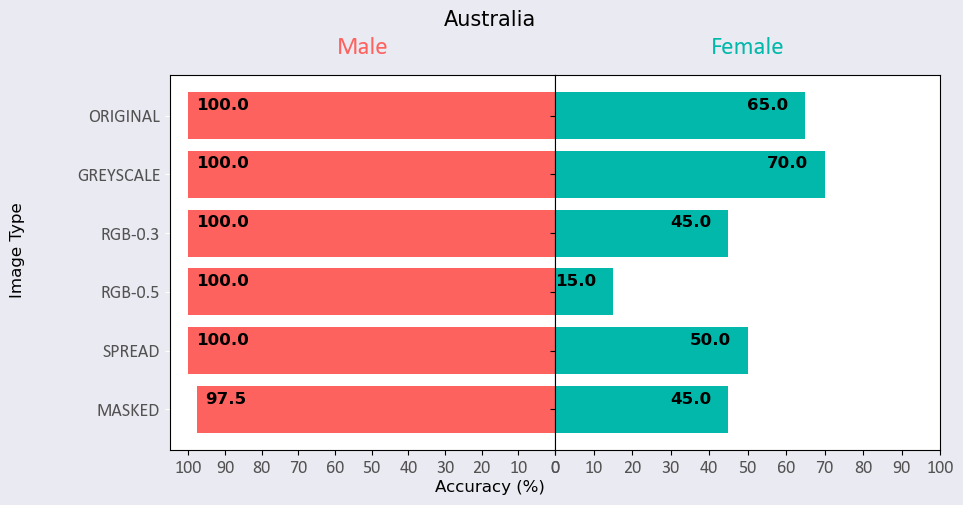

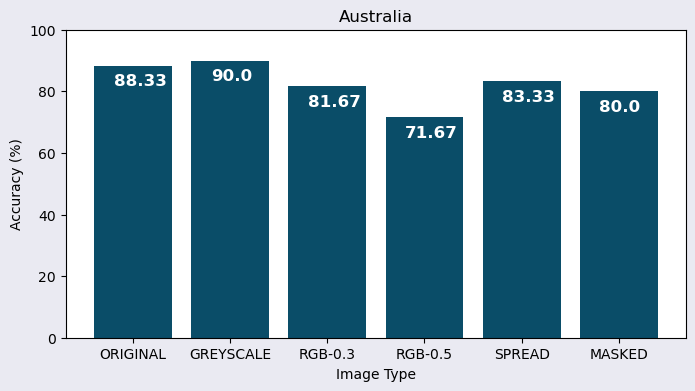

Bangladesh


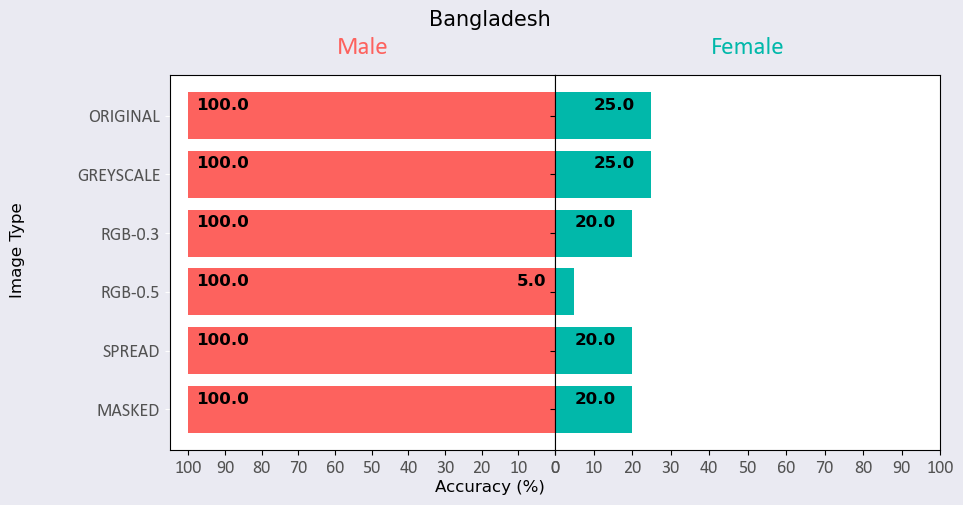

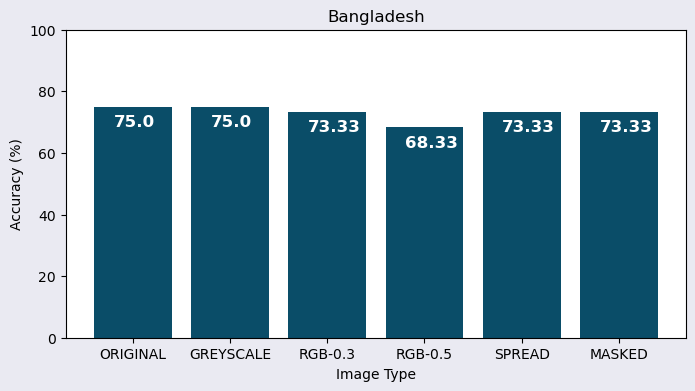

England


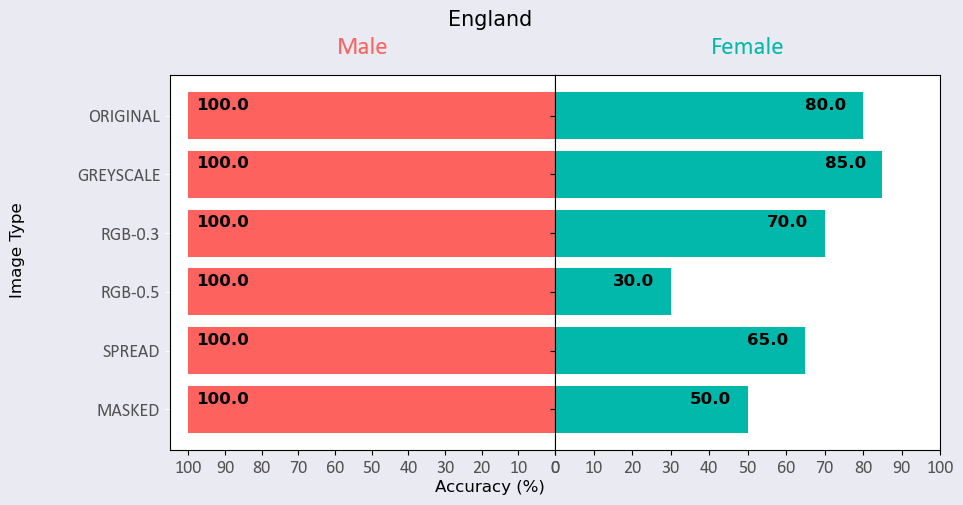

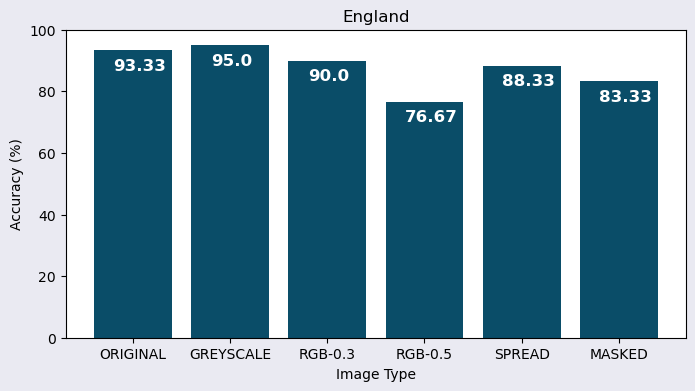

India


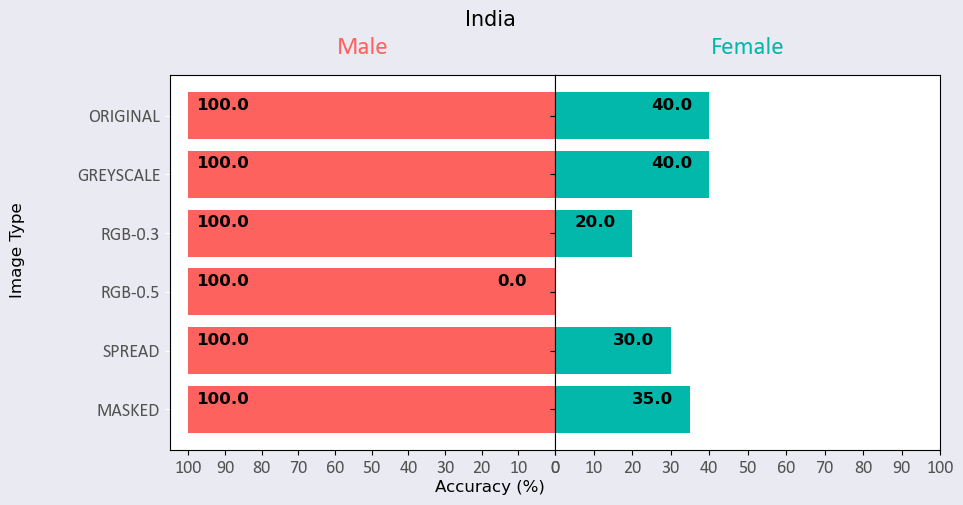

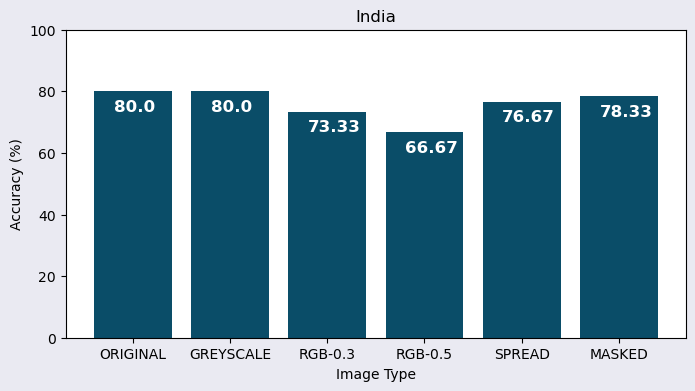

New Zealand


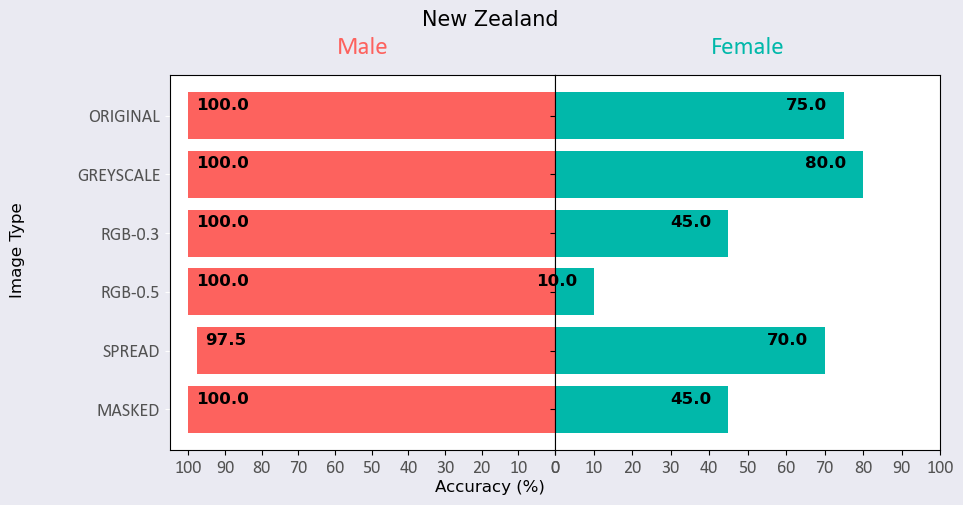

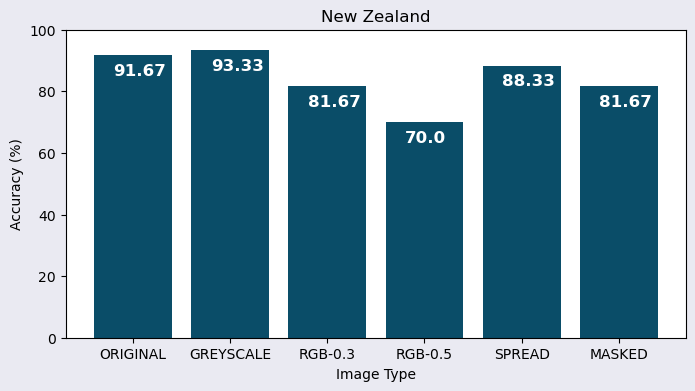

Pakistan


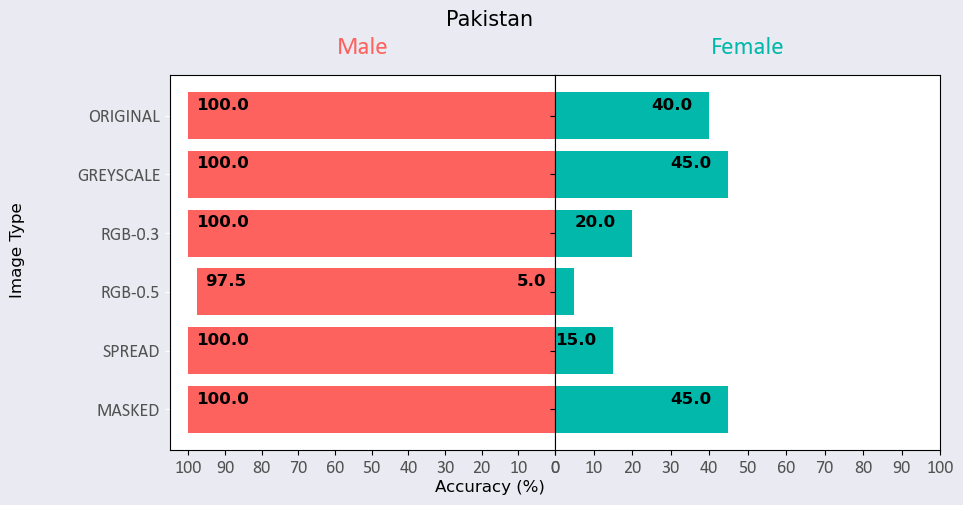

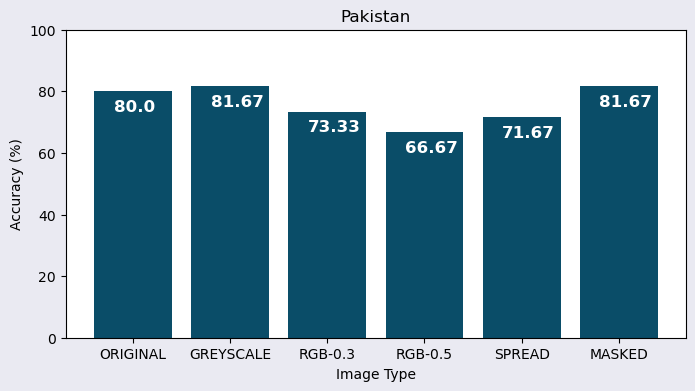

South Africa


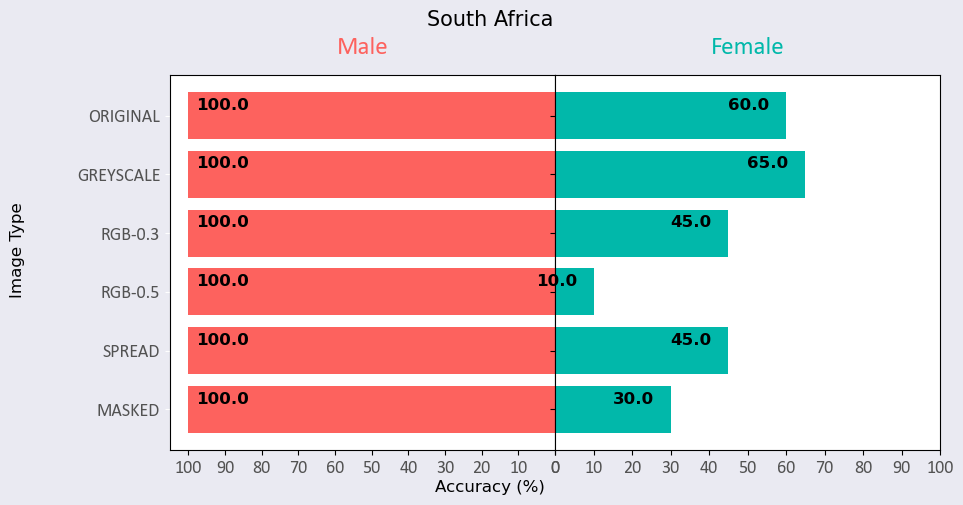

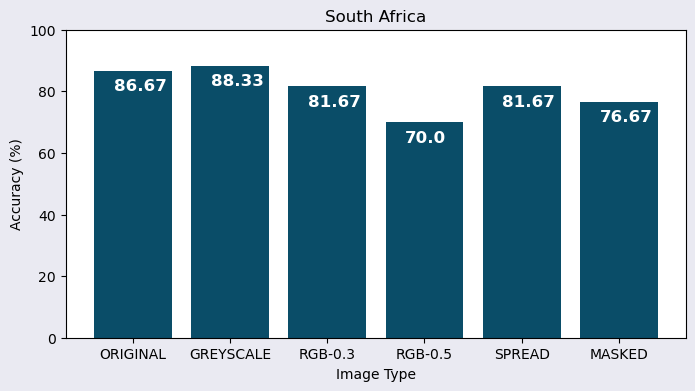

West Indies


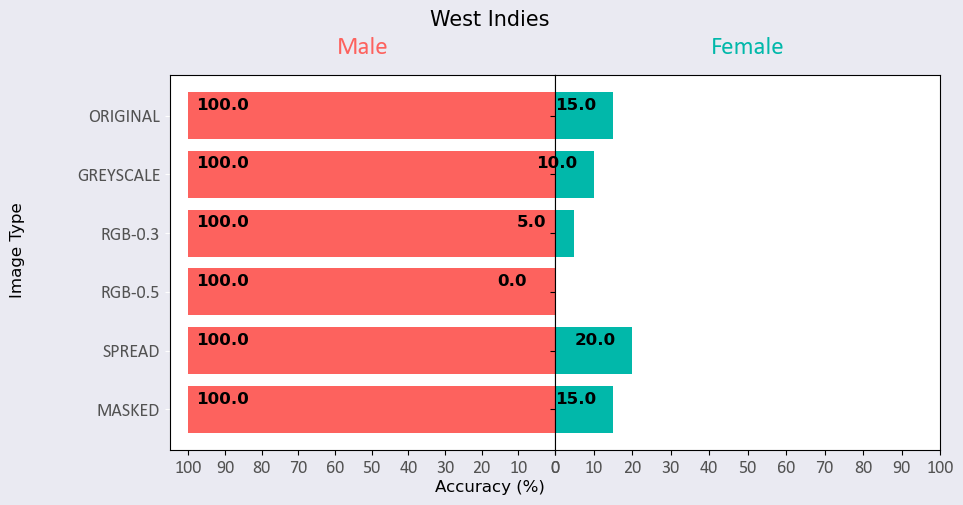

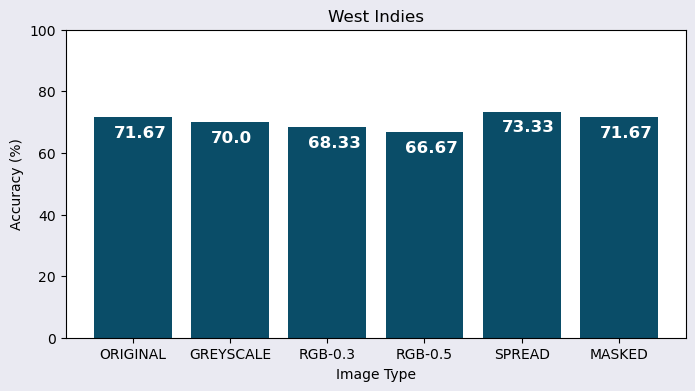

In [7]:
API_NAME_ORG = 'deepface_without_face_detection'
img_type = "original" ## change this when you use "deepface-fine" as API
num_img_category = 1 ## change this when you use "deepface-fine" as API

API_NAME = API_NAME_ORG
if API_NAME == 'deepface-fine':
    if img_type == "original":
        API_NAME = 'result_'+str(num_img_category)
    else:
        API_NAME = 'result_'+img_type+"_"+str(num_img_category)

test_data_path = 'test_data_trained_on_'+img_type
res_csv_path = './../Results in csv files/'+API_NAME
save_fig_path = 'plots/'+API_NAME
create_folder(save_fig_path)
countries = os.listdir(res_csv_path)
df_overall = pd.DataFrame()
for country in countries:
    country = country.split('.')[0]
    print(country)
    df = doAnalysis(country,res_csv_path+'/'+country+'.csv',test_data_path,API_NAME_ORG,save_fig_path+'/')
    df_overall = df_overall.append(df)
#     break
df_overall = df_overall.reset_index()
df_overall = df_overall.drop('index',axis = 1)

In [8]:
len(df_overall)

480

In [9]:
save_fig_path = "plots/"+API_NAME+"/"
def overall_accuracy(df):
    img_types = df.columns[2:-2]
#     print(df.columns)
#     print(img_types)
    df_copy = df.copy()
    df_res = pd.DataFrame()
    df_res['image type'] = ['male','female','combined']
    for img_type in img_types:
        print("Image Type : "+img_type)
        print(len(df_copy))
        total = len(df_copy)
        df_male = df_copy[df_copy['gender'] == 'M']
        df_female = df_copy[df_copy['gender'] == 'F']

        total_male = len(df_male)
        total_female = len(df_female)

        predicted_male = len(df_male[df_male[img_type] == 'M'])
        predicted_female = len(df_female[df_female[img_type] == 'F'])

        total_correct_prediction = len(df_copy[df_copy['gender'] == df_copy[img_type]])
#         print("Total : ",total)
#         print("Total correct prediction : ",total_correct_prediction)
        
        
        
        print("Overall Male accuracy : %0.2f"%((predicted_male/total_male)*100))
        print("Overall Female accuracy : %0.2f"%((predicted_female/total_female)*100))
        print("Overall Accuracy : %0.2f"%((total_correct_prediction/total)*100))
        print()
        lis = ["%0.2f"%((predicted_male/total_male)*100),"%0.2f"%((predicted_female/total_female)*100),"%0.2f"%((total_correct_prediction/total)*100)]
        df_res[img_type] = lis
    print(df_res)
    df_res.to_csv(save_fig_path+"overall_accuracy_all.csv",index = False)

In [10]:
overall_accuracy(df_overall)

Image Type : Greyish
480
Overall Male accuracy : 100.00
Overall Female accuracy : 52.50
Overall Accuracy : 84.17

Image Type : masked
480
Overall Male accuracy : 99.69
Overall Female accuracy : 35.62
Overall Accuracy : 78.33

Image Type : normal
480
Overall Male accuracy : 100.00
Overall Female accuracy : 50.00
Overall Accuracy : 83.33

Image Type : RGB0.3 Noise
480
Overall Male accuracy : 100.00
Overall Female accuracy : 33.75
Overall Accuracy : 77.92

Image Type : RGB0.5 Noise
480
Overall Male accuracy : 99.69
Overall Female accuracy : 9.38
Overall Accuracy : 69.58

Image Type : Spread Noise
480
Overall Male accuracy : 99.69
Overall Female accuracy : 39.38
Overall Accuracy : 79.58

  image type Greyish masked  normal RGB0.3 Noise RGB0.5 Noise Spread Noise
0       male  100.00  99.69  100.00       100.00        99.69        99.69
1     female   52.50  35.62   50.00        33.75         9.38        39.38
2   combined   84.17  78.33   83.33        77.92        69.58        79.58


## Just for simply copying the result into google sheet

In [11]:
save_fig_path = "plots/"+API_NAME+"/"
files = os.listdir(save_fig_path)

df_all = pd.DataFrame()
df_all['country'] = None
for file in files: # countries
    pref = file.split("_")[0]
    if pref != 'accuracy':
        continue
    df = pd.read_csv(save_fig_path+'/'+file)
#     print(df)
#     break
    country = file.split("_")[-1].split(".")[0]
#     print(country)
    img_types = df.columns[1:]
    if len(df_all.columns) == 1:
        all_columns = []
        for img_type in img_types:
            all_columns.append('male-'+img_type)
            all_columns.append('female-'+img_type)
            all_columns.append('overall-'+img_type)
    #     print(all_columns)
        for col in all_columns:
            df_all[col] = None
    data = [country]
    for img_type in img_types:
        data.append(df[img_type][1])
        data.append(df[img_type][2])
        data.append(df[img_type][0])
    print(data)
    df_all.loc[len(df_all.index)] = data

df_all.to_csv(save_fig_path+"all_accuracy.csv",index = False)

['Australia', 100.0, 65.0, 88.33, 100.0, 70.0, 90.0, 100.0, 45.0, 81.67, 100.0, 15.0, 71.67, 100.0, 50.0, 83.33, 97.5, 45.0, 80.0]
['Bangladesh', 100.0, 25.0, 75.0, 100.0, 25.0, 75.0, 100.0, 20.0, 73.33, 100.0, 5.0, 68.33, 100.0, 20.0, 73.33, 100.0, 20.0, 73.33]
['England', 100.0, 80.0, 93.33, 100.0, 85.0, 95.0, 100.0, 70.0, 90.0, 100.0, 30.0, 76.67, 100.0, 65.0, 88.33, 100.0, 50.0, 83.33]
['India', 100.0, 40.0, 80.0, 100.0, 40.0, 80.0, 100.0, 20.0, 73.33, 100.0, 0.0, 66.67, 100.0, 30.0, 76.67, 100.0, 35.0, 78.33]
['New Zealand', 100.0, 75.0, 91.67, 100.0, 80.0, 93.33, 100.0, 45.0, 81.67, 100.0, 10.0, 70.0, 97.5, 70.0, 88.33, 100.0, 45.0, 81.67]
['Pakistan', 100.0, 40.0, 80.0, 100.0, 45.0, 81.67, 100.0, 20.0, 73.33, 97.5, 5.0, 66.67, 100.0, 15.0, 71.67, 100.0, 45.0, 81.67]
['South Africa', 100.0, 60.0, 86.67, 100.0, 65.0, 88.33, 100.0, 45.0, 81.67, 100.0, 10.0, 70.0, 100.0, 45.0, 81.67, 100.0, 30.0, 76.67]
['West Indies', 100.0, 15.0, 71.67, 100.0, 10.0, 70.0, 100.0, 5.0, 68.33, 100.0,